In [15]:
# ===============================
# Core & Utilities
# ===============================
import os
import numpy as np
import pandas as pd
import cv2
import pytesseract
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from PIL import Image
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize

(np.float64(-0.5), np.float64(1809.5), np.float64(795.5), np.float64(-0.5))

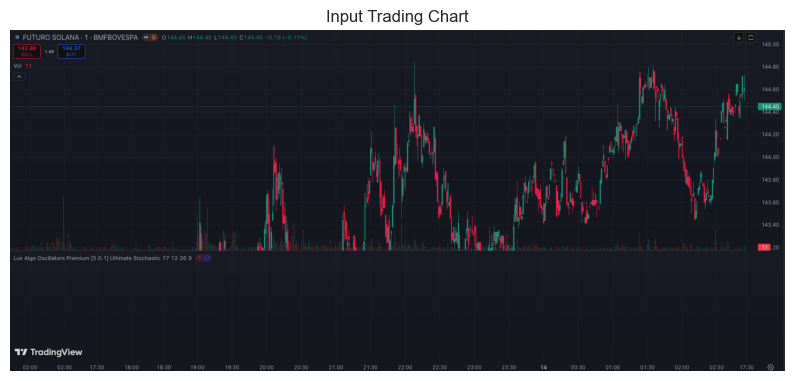

In [16]:
plt.style.use("seaborn-v0_8-darkgrid")

IMAGE_PATH = "../data/sample_chart.png"

assert os.path.exists(IMAGE_PATH), "Chart image not found"

img_bgr = cv2.imread(IMAGE_PATH)
if img_bgr is None:
    raise ValueError("Failed to load image")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(img_rgb)
plt.title("Input Trading Chart")
plt.axis("off")

(np.float64(-0.5), np.float64(1809.5), np.float64(795.5), np.float64(-0.5))

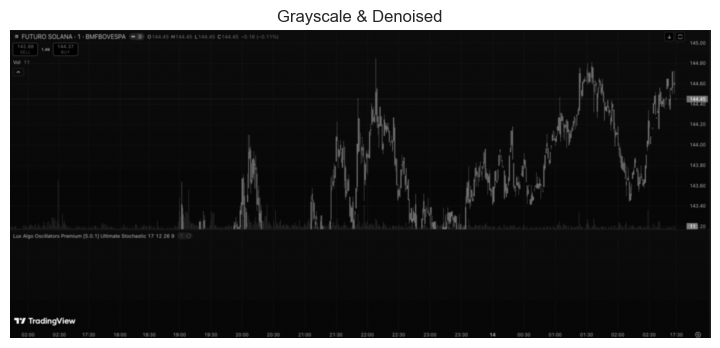

In [17]:
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(10, 4))
plt.imshow(gray, cmap="gray")
plt.title("Grayscale & Denoised")
plt.axis("off")

(np.float64(-0.5), np.float64(1809.5), np.float64(795.5), np.float64(-0.5))

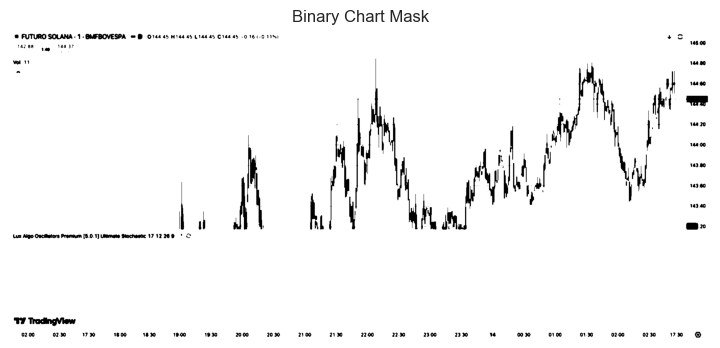

In [18]:
thresh = threshold_otsu(gray)
binary = gray < thresh

plt.figure(figsize=(10, 4))
plt.imshow(binary, cmap="gray")
plt.title("Binary Chart Mask")
plt.axis("off")

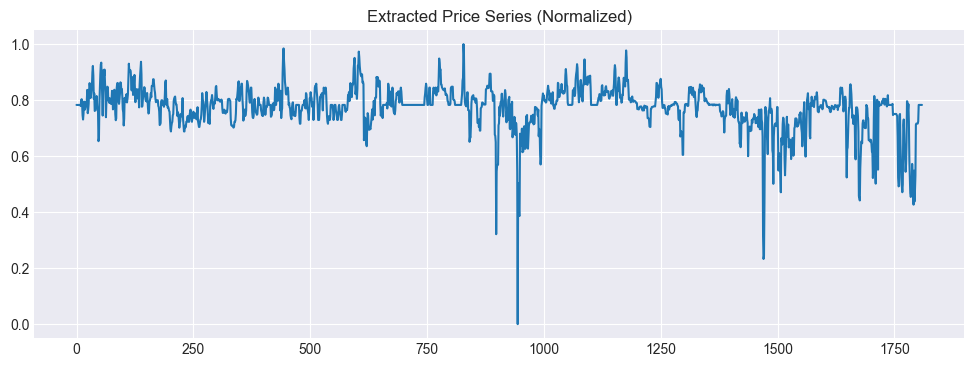

In [19]:
height, width = binary.shape
price_pixels = []

for x in range(width):
    ys = np.where(binary[:, x])[0]
    price_pixels.append(np.mean(ys) if len(ys) > 0 else np.nan)

price_pixels = pd.Series(price_pixels).interpolate().to_numpy()

price_series = height - price_pixels
price_series = (price_series - price_series.min()) / (
    price_series.max() - price_series.min()
)

plt.figure(figsize=(12, 4))
plt.plot(price_series)
plt.title("Extracted Price Series (Normalized)")
plt.show()